In [1]:
import h5py
import numpy as np

# Define path
mat_path = r'E:\1 Paper MCT\Cutting Tool Paper\Dataset\cutting tool data\mat files data\AE_ALL.mat'

# Class mapping: desired label → source key in .mat file
class_map = {
    'BF': 'BF',
    'GF': 'GF',
    'TF': 'BFI',  # Use BFI but label as TF
    'N':  'NI'    # Use NI but label as N
}

channel_index = 0  # Only use Channel 1 (Python index 0)

# Container for loaded data
raw_signals = {}

with h5py.File(mat_path, 'r') as mat_file:
    ae_all = mat_file['AE_ALL']
    
    for label, mat_key in class_map.items():
        print(f"Loading: {label} (from {mat_key})")
        # Get reference for specified channel
        cls_refs = ae_all[mat_key]  # shape: (1, 4) in h5py (matlab cell array)
        ref = cls_refs[channel_index][0]  # Select channel 1
        dataset = mat_file[ref]
        signal_array = np.array(dataset)  # shape: (1000000, 40)
        
        # Store 40 signals for this class
        signals = [signal_array[:, i] for i in range(signal_array.shape[1])]  # list of 1D arrays
        raw_signals[label] = signals
        
        print(f"{label}: Loaded {len(signals)} signals, shape each = {signals[0].shape}")


Loading: BF (from BF)
BF: Loaded 40 signals, shape each = (1000000,)
Loading: GF (from GF)
GF: Loaded 40 signals, shape each = (1000000,)
Loading: TF (from BFI)
TF: Loaded 40 signals, shape each = (1000000,)
Loading: N (from NI)
N: Loaded 40 signals, shape each = (1000000,)


In [2]:
def segment_signal(signal, frame_size=10000, num_frames=10):
    """Segment a 1D signal into `num_frames` of `frame_size` length."""
    segments = []
    for i in range(num_frames):
        start = i * frame_size
        end = start + frame_size
        segment = signal[start:end]
        segments.append(segment)
    return segments  # list of 1D arrays

# Segment all signals in all classes
segmented_data = {}

for cls, signals in raw_signals.items():
    all_frames = []
    for sig in signals:
        frames = segment_signal(sig, frame_size=10000, num_frames=10)
        all_frames.extend(frames)
    segmented_data[cls] = all_frames
    print(f"{cls}: {len(all_frames)} frames → shape each = {all_frames[0].shape}")


BF: 400 frames → shape each = (10000,)
GF: 400 frames → shape each = (10000,)
TF: 400 frames → shape each = (10000,)
N: 400 frames → shape each = (10000,)


In [3]:
import pywt
import numpy as np

def denoise_wavelet(frame, wavelet='db4', level=3):
    """Apply wavelet denoising to a single 1D signal frame."""
    coeffs = pywt.wavedec(frame, wavelet=wavelet, level=level)
    
    # Universal threshold
    sigma = np.median(np.abs(coeffs[-1])) / 0.6745
    threshold = sigma * np.sqrt(2 * np.log(len(frame)))
    
    # Apply soft thresholding to detail coefficients
    coeffs_thresh = [coeffs[0]] + [pywt.threshold(c, threshold, mode='soft') for c in coeffs[1:]]
    
    # Reconstruct signal
    denoised = pywt.waverec(coeffs_thresh, wavelet=wavelet)
    return denoised[:len(frame)]  # Trim to original length


In [4]:
denoised_data = {}

for cls, frames in segmented_data.items():
    denoised_frames = [denoise_wavelet(frame) for frame in frames]
    denoised_data[cls] = denoised_frames
    print(f"{cls}: Denoised {len(denoised_frames)} frames")


BF: Denoised 400 frames
GF: Denoised 400 frames
TF: Denoised 400 frames
N: Denoised 400 frames


In [5]:
def compute_energy(frame):
    """Compute signal energy (sum of squares)."""
    return np.sum(frame ** 2)

def select_burst_frames(frames, top_ratio=0.5):
    """Select top `top_ratio` burst frames based on energy."""
    energies = np.array([compute_energy(f) for f in frames])
    threshold = np.percentile(energies, 100 * (1 - top_ratio))
    selected = [f for f, e in zip(frames, energies) if e >= threshold]
    return selected, energies, threshold


In [6]:
burst_selected_data = {}
burst_stats = {}

for cls, frames in denoised_data.items():
    selected, energies, threshold = select_burst_frames(frames, top_ratio=0.5)
    burst_selected_data[cls] = selected
    burst_stats[cls] = {
        'total_frames': len(frames),
        'selected_frames': len(selected),
        'energy_threshold': threshold
    }
    print(f"{cls}: Selected {len(selected)} burst frames (threshold = {threshold:.2e})")


BF: Selected 200 burst frames (threshold = 9.73e+01)
GF: Selected 200 burst frames (threshold = 1.75e+01)
TF: Selected 200 burst frames (threshold = 8.80e+01)
N: Selected 200 burst frames (threshold = 8.94e+01)


In [7]:
from scipy.stats import skew, kurtosis, entropy
from scipy.signal import welch, find_peaks
import numpy as np

def extract_td_fd_features(frame, fs=1e6):
    features = []

    # Time-Domain Features
    mean_val = np.mean(frame)
    std_val = np.std(frame)
    var_val = np.var(frame)
    rms_val = np.sqrt(np.mean(frame**2))
    peak_val = np.max(np.abs(frame))
    ptp_val = np.ptp(frame)  # Peak-to-peak
    crest_factor = peak_val / rms_val if rms_val != 0 else 0
    impulse_factor = peak_val / np.mean(np.abs(frame)) if np.mean(np.abs(frame)) != 0 else 0
    shape_factor = rms_val / np.mean(np.abs(frame)) if np.mean(np.abs(frame)) != 0 else 0
    margin_factor = peak_val / (np.mean(np.sqrt(np.abs(frame)))**2) if np.mean(np.sqrt(np.abs(frame))) != 0 else 0
    skewness = skew(frame)
    kurt = kurtosis(frame)
    energy = np.sum(frame**2)
    zcr = ((frame[:-1] * frame[1:]) < 0).sum()
    mav = np.mean(np.abs(frame))
    max_val = np.max(frame)
    min_val = np.min(frame)
    range_val = max_val - min_val
    duration = len(frame) / fs
    envelope_area = np.trapz(np.abs(frame))

    # Frequency-Domain Features (Welch)
    freqs, psd = welch(frame, fs=fs, nperseg=1024)
    psd = np.nan_to_num(psd)

    spectral_energy = np.sum(psd)
    spectral_centroid = np.sum(freqs * psd) / np.sum(psd) if np.sum(psd) != 0 else 0
    spectral_entropy = entropy(psd)
    spectral_kurtosis = kurtosis(psd)
    spectral_skewness = skew(psd)
    spectral_flatness = np.exp(np.mean(np.log(psd + 1e-12))) / np.mean(psd) if np.mean(psd) != 0 else 0
    dominant_freq = freqs[np.argmax(psd)]
    median_freq = freqs[np.argsort(np.cumsum(psd) >= np.sum(psd)/2)[0]]
    mean_freq = np.sum(freqs * psd) / np.sum(psd) if np.sum(psd) != 0 else 0
    freq_variance = np.var(psd)
    freq_rms = np.sqrt(np.mean(psd**2))
    freq_spread = np.std(freqs)

    # Optional: THD (requires sinusoidal assumption, simplified)
    harmonics, _ = find_peaks(psd, height=np.max(psd)*0.1)
    thd = np.sum(psd[harmonics[1:]]) / psd[harmonics[0]] if len(harmonics) > 1 else 0

    features.extend([
        mean_val, rms_val, std_val, var_val,
        skewness, kurt, peak_val, ptp_val,
        crest_factor, impulse_factor, shape_factor, margin_factor,
        energy, max_val, min_val, range_val,
        zcr, duration, mav, envelope_area,
        mean_freq, median_freq, dominant_freq, spectral_centroid,
        spectral_entropy, spectral_kurtosis, spectral_skewness,
        spectral_flatness, spectral_energy, freq_variance,
        freq_rms, freq_spread, thd
    ])

    return features


In [8]:
import pandas as pd

td_fd_features = []
td_fd_labels = []

for cls, frames in burst_selected_data.items():
    for frame in frames:
        features = extract_td_fd_features(frame)
        td_fd_features.append(features)
        td_fd_labels.append(cls)

# Create a DataFrame
feature_names = [
    "Mean", "RMS", "STD", "Variance", "Skewness", "Kurtosis",
    "Peak", "PeakToPeak", "CrestFactor", "ImpulseFactor", "ShapeFactor", "MarginFactor",
    "SignalEnergy", "MaxVal", "MinVal", "Range", "ZCR", "Duration", "MAV", "EnvelopeArea",
    "MeanFreq", "MedianFreq", "DominantFreq", "SpectralCentroid", "SpectralEntropy",
    "SpectralKurtosis", "SpectralSkewness", "SpectralFlatness", "SpectralEnergy",
    "FreqVariance", "FreqRMS", "FreqSpread", "THD"
]

td_fd_df = pd.DataFrame(td_fd_features, columns=feature_names)
td_fd_df['Label'] = td_fd_labels

print("✅ TD + FD feature extraction complete.")
print("DataFrame shape:", td_fd_df.shape)
td_fd_df.head()


✅ TD + FD feature extraction complete.
DataFrame shape: (800, 34)


,Mean,RMS,STD,Variance,Skewness,Kurtosis,Peak,PeakToPeak,CrestFactor,ImpulseFactor,...,SpectralEntropy,SpectralKurtosis,SpectralSkewness,SpectralFlatness,SpectralEnergy,FreqVariance,FreqRMS,FreqSpread,THD,Label
0,0.001428,0.119172,0.119163,0.014200,-0.045152,4.553338,0.647373,1.225040,5.432271,8.337815,...,3.158156,98.562849,9.239518,0.003852,0.000017,3.606262e-14,1.926429e-07,144619.201843,10.456552,BF
1,0.001484,0.105900,0.105890,0.011213,-0.283976,5.775529,0.625789,1.232207,5.909244,9.571586,...,2.466786,167.086528,12.654246,0.001571,0.000012,4.211594e-14,2.065004e-07,144619.201843,0.000000,BF
2,0.001048,0.120137,0.120133,0.014432,-0.049769,6.159776,0.744014,1.471063,6.193036,9.957408,...,2.091789,230.809188,14.405772,0.000493,0.000014,7.661196e-14,2.780859e-07,144619.201843,0.000000,BF
3,0.001416,0.106272,0.106262,0.011292,0.006337,7.338358,0.715272,1.310700,6.730587,10.599260,...,3.289770,65.368995,7.536869,0.005276,0.000012,1.585263e-14,1.281516e-07,144619.201843,9.895905,BF
4,0.001207,0.111461,0.111455,0.012422,0.021046,8.325233,0.805422,1.411601,7.226013,12.240260,...,3.308154,44.817981,6.403082,0.005371,0.000014,1.777266e-14,1.359399e-07,144619.201843,7.315239,BF


In [9]:
import pywt
from scipy.stats import entropy, skew, kurtosis



In [10]:
def extract_tfd_features_cwt(frame, wavelet='cmor1.5-1.0', fs=1e6, num_scales=64):
    """
    Extract time-frequency domain features from a 1D frame using Continuous Wavelet Transform (CWT).
    """
    scales = np.arange(1, num_scales + 1)
    coef, _ = pywt.cwt(frame, scales=scales, wavelet=wavelet, sampling_period=1/fs)

    scalogram = np.abs(coef)  # magnitude of CWT coefficients
    tfd_energy = np.sum(scalogram**2)
    tfd_entropy = entropy(scalogram.flatten())
    tfd_mean = np.mean(scalogram)
    tfd_std = np.std(scalogram)
    tfd_max = np.max(scalogram)
    tfd_kurt = kurtosis(scalogram.flatten())
    tfd_skew = skew(scalogram.flatten())
    tfd_centroid = np.sum(scalogram * np.arange(scalogram.shape[0])[:, None]) / np.sum(scalogram)

    # Ridge Energy Ratio (top 5% values vs total)
    flat = scalogram.flatten()
    top_k = np.percentile(flat, 95)
    ridge_energy = np.sum(flat[flat >= top_k]) / np.sum(flat)

    return [
        tfd_energy, tfd_entropy, tfd_mean, tfd_std,
        tfd_max, tfd_kurt, tfd_skew, tfd_centroid,
        ridge_energy
    ]


In [11]:
tfd_features = []
tfd_labels = []

for cls, frames in burst_selected_data.items():
    for frame in frames:
        tfd_feat = extract_tfd_features_cwt(frame)
        tfd_features.append(tfd_feat)
        tfd_labels.append(cls)


In [12]:
tfd_feature_names = [
    "TFD_Energy", "TFD_Entropy", "TFD_Mean", "TFD_STD", "TFD_Max",
    "TFD_Kurtosis", "TFD_Skewness", "TFD_Centroid", "TFD_RidgeEnergyRatio"
]

tfd_df = pd.DataFrame(tfd_features, columns=tfd_feature_names)
tfd_df['Label'] = tfd_labels

print("✅ CWT-based TFD feature extraction complete.")
print("TFD DataFrame shape:", tfd_df.shape)
tfd_df.head()


✅ CWT-based TFD feature extraction complete.
TFD DataFrame shape: (800, 10)


,TFD_Energy,TFD_Entropy,TFD_Mean,TFD_STD,TFD_Max,TFD_Kurtosis,TFD_Skewness,TFD_Centroid,TFD_RidgeEnergyRatio,Label
0,31960.239027,12.470357,0.118921,0.189198,1.544643,8.930663,2.684063,45.805836,0.312615,BF
1,32919.039972,12.299087,0.105975,0.200513,1.699516,13.874634,3.412275,45.645199,0.391342,BF
2,44763.931797,12.271250,0.121925,0.234687,2.152694,16.399034,3.572573,44.904295,0.389232,BF
3,23878.765488,12.468185,0.102888,0.163477,1.152047,8.302048,2.643953,46.151481,0.314814,BF
4,26039.813417,12.375514,0.100227,0.175048,1.260765,9.687068,2.924291,46.733203,0.356213,BF


In [13]:
from scipy.signal import hilbert
from scipy.fftpack import fft2
from scipy.linalg import toeplitz

def extract_hos_features(frame):
    features = []

    # Central Moments (3rd, 4th, 5th)
    centered = frame - np.mean(frame)
    m3 = np.mean(centered**3)
    m4 = np.mean(centered**4)
    m5 = np.mean(centered**5)

    # Cumulants
    c3 = m3
    c4 = m4 - 3 * (np.var(frame)**2)

    # Gaussianity index (c4 / m4)
    g_index = c4 / m4 if m4 != 0 else 0

    # Bispectrum (simplified approximation)
    analytic_signal = hilbert(frame)
    N = len(frame) // 2
    X = fft2(np.outer(analytic_signal[:N], analytic_signal[:N]))
    bispec = np.abs(X)
    bicoherence = bispec / (np.outer(np.abs(analytic_signal[:N])**2, np.abs(analytic_signal[:N])**2) + 1e-12)

    bispec_mean = np.mean(bispec)
    bicoherence_mean = np.mean(bicoherence)

    # Nonlinearity index: c3^2 + c4^2
    nonlinearity_index = c3**2 + c4**2

    features.extend([
        m3, m4, m5,     # Higher-order moments
        c3, c4,         # Cumulants
        g_index,
        bispec_mean,
        bicoherence_mean,
        nonlinearity_index
    ])

    return features


In [14]:
hos_features = []
hos_labels = []

for cls, frames in burst_selected_data.items():
    for frame in frames:
        hos_feat = extract_hos_features(frame)
        hos_features.append(hos_feat)
        hos_labels.append(cls)


In [15]:
hos_feature_names = [
    "Moment3", "Moment4", "Moment5",
    "Cumulant3", "Cumulant4",
    "GaussianityIndex",
    "BispectrumMean", "BicoherenceMean",
    "NonlinearityIndex"
]

hos_df = pd.DataFrame(hos_features, columns=hos_feature_names)
hos_df['Label'] = hos_labels

print("✅ HOS feature extraction complete.")
print("HOS DataFrame shape:", hos_df.shape)
hos_df.head()


✅ HOS feature extraction complete.
HOS DataFrame shape: (800, 10)


,Moment3,Moment4,Moment5,Cumulant3,Cumulant4,GaussianityIndex,BispectrumMean,BicoherenceMean,NonlinearityIndex,Label
0,-0.000076,0.001523,0.000015,-0.000076,0.000918,0.602825,9.502422,6.820855e+06,8.487715e-07,BF
1,-0.000337,0.001103,-0.000096,-0.000337,0.000726,0.658140,4.092278,1.673120e+06,6.409216e-07,BF
2,-0.000086,0.001908,-0.000014,-0.000086,0.001283,0.672481,3.425857,1.405418e+07,1.653394e-06,BF
3,0.000008,0.001318,0.000102,0.000008,0.000936,0.709819,8.074595,8.919394e+07,8.755155e-07,BF
4,0.000029,0.001748,0.000154,0.000029,0.001285,0.735105,7.683634,2.247736e+09,1.651241e-06,BF


In [20]:
def extract_burst_features(frame, fs=1e6, threshold_ratio=0.25):
    features = []

    threshold = threshold_ratio * np.max(np.abs(frame))
    indices = np.where(np.abs(frame) > threshold)[0]

    if len(indices) == 0:
        # No bursts found — fill zeros
        return [0]*10

    # Group consecutive indices as bursts
    burst_starts = [indices[0]]
    burst_durations = []
    current_duration = 1

    for i in range(1, len(indices)):
        if indices[i] == indices[i-1] + 1:
            current_duration += 1
        else:
            burst_durations.append(current_duration / fs)
            burst_starts.append(indices[i])
            current_duration = 1
    burst_durations.append(current_duration / fs)

    num_bursts = len(burst_durations)
    burst_energies = [np.sum(frame[s:s+int(d*fs)]**2) for s, d in zip(burst_starts, burst_durations)]
    burst_peaks = [np.max(np.abs(frame[s:s+int(d*fs)])) for s, d in zip(burst_starts, burst_durations)]
    rms_bursts = [np.sqrt(np.mean(frame[s:s+int(d*fs)]**2)) for s, d in zip(burst_starts, burst_durations)]
    inter_burst_intervals = np.diff(burst_starts) / fs if len(burst_starts) > 1 else np.array([])

    total_event_duration = np.sum(burst_durations)
    cumulative_counts = np.sum([int(d*fs) for d in burst_durations])

    features.extend([
        num_bursts,
        np.mean(burst_durations) if len(burst_durations) > 0 else 0,
        np.mean(inter_burst_intervals) if len(inter_burst_intervals) > 0 else 0,
        np.mean(burst_energies) if len(burst_energies) > 0 else 0,
        np.mean(burst_peaks) if len(burst_peaks) > 0 else 0,
        np.mean(rms_bursts) if len(rms_bursts) > 0 else 0,
        cumulative_counts,
        total_event_duration,
        np.max(burst_peaks) if len(burst_peaks) > 0 else 0,
        np.min(burst_peaks) if len(burst_peaks) > 0 else 0
    ])

    return features


In [21]:
burst_features = []
burst_labels = []

for cls, frames in burst_selected_data.items():
    for frame in frames:
        burst_feat = extract_burst_features(frame)
        burst_features.append(burst_feat)
        burst_labels.append(cls)


In [22]:
burst_feature_names = [
    "NumBursts", "AvgBurstDuration", "AvgInterBurstInterval",
    "AvgBurstEnergy", "AvgBurstPeak", "AvgBurstRMS",
    "CumulativeCounts", "TotalEventDuration",
    "MaxBurstPeak", "MinBurstPeak"
]

burst_df = pd.DataFrame(burst_features, columns=burst_feature_names)
burst_df['Label'] = burst_labels

print("✅ AE Burst feature extraction complete.")
print("Burst Feature DataFrame shape:", burst_df.shape)
burst_df.head()


✅ AE Burst feature extraction complete.
Burst Feature DataFrame shape: (800, 11)


,NumBursts,AvgBurstDuration,AvgInterBurstInterval,AvgBurstEnergy,AvgBurstPeak,AvgBurstRMS,CumulativeCounts,TotalEventDuration,MaxBurstPeak,MinBurstPeak,Label
0,110,0.000013,0.000083,0.982442,0.289021,0.245353,1377,0.001377,0.647373,0.162102,BF
1,76,0.000014,0.000120,1.108053,0.303540,0.254080,1041,0.001041,0.625789,0.158202,BF
2,88,0.000012,0.000104,1.228556,0.324953,0.280389,1065,0.001065,0.744014,0.186331,BF
3,74,0.000011,0.000096,0.983079,0.304986,0.262904,781,0.000781,0.715272,0.179833,BF
4,65,0.000011,0.000141,1.313262,0.352183,0.302386,719,0.000719,0.805422,0.203038,BF


In [23]:
# Drop duplicate Label columns to avoid merge issues
td_fd_df = td_fd_df.drop(columns=['Label'])
tfd_df = tfd_df.drop(columns=['Label'])
hos_df = hos_df.drop(columns=['Label'])
burst_df = burst_df.drop(columns=['Label'])

# Concatenate all features
combined_features = pd.concat([td_fd_df, tfd_df, hos_df, burst_df], axis=1)
combined_features['Label'] = burst_labels  # Same labels for all

print("✅ All features combined.")
print("Final feature shape:", combined_features.shape)
combined_features.head()


✅ All features combined.
Final feature shape: (800, 62)


,Mean,RMS,STD,Variance,Skewness,Kurtosis,Peak,PeakToPeak,CrestFactor,ImpulseFactor,...,AvgBurstDuration,AvgInterBurstInterval,AvgBurstEnergy,AvgBurstPeak,AvgBurstRMS,CumulativeCounts,TotalEventDuration,MaxBurstPeak,MinBurstPeak,Label
0,0.001428,0.119172,0.119163,0.014200,-0.045152,4.553338,0.647373,1.225040,5.432271,8.337815,...,0.000013,0.000083,0.982442,0.289021,0.245353,1377,0.001377,0.647373,0.162102,BF
1,0.001484,0.105900,0.105890,0.011213,-0.283976,5.775529,0.625789,1.232207,5.909244,9.571586,...,0.000014,0.000120,1.108053,0.303540,0.254080,1041,0.001041,0.625789,0.158202,BF
2,0.001048,0.120137,0.120133,0.014432,-0.049769,6.159776,0.744014,1.471063,6.193036,9.957408,...,0.000012,0.000104,1.228556,0.324953,0.280389,1065,0.001065,0.744014,0.186331,BF
3,0.001416,0.106272,0.106262,0.011292,0.006337,7.338358,0.715272,1.310700,6.730587,10.599260,...,0.000011,0.000096,0.983079,0.304986,0.262904,781,0.000781,0.715272,0.179833,BF
4,0.001207,0.111461,0.111455,0.012422,0.021046,8.325233,0.805422,1.411601,7.226013,12.240260,...,0.000011,0.000141,1.313262,0.352183,0.302386,719,0.000719,0.805422,0.203038,BF


In [24]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Separate features and label
X = combined_features.drop(columns=['Label']).values
y = combined_features['Label'].values

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Encode labels to numeric
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print("✅ Features normalized and labels encoded.")
print("X_scaled shape:", X_scaled.shape)
print("y_encoded shape:", y_encoded.shape)


✅ Features normalized and labels encoded.
X_scaled shape: (800, 61)
y_encoded shape: (800,)


In [25]:
import pandas as pd

# Reconstruct feature DataFrame with names
final_feature_names = combined_features.drop(columns=['Label']).columns.tolist()
df_export = pd.DataFrame(X_scaled, columns=final_feature_names)
df_export['Label'] = y
df_export['EncodedLabel'] = y_encoded

# Export to Excel
excel_path = 'full_ae_features.xlsx'
df_export.to_excel(excel_path, index=False)

print(f"✅ Feature set saved to Excel at: {excel_path}")


✅ Feature set saved to Excel at: full_ae_features.xlsx


In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

# Split
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y_encoded, test_size=0.2, stratify=y_encoded)

# Convert to torch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)

# VAE architecture
class VAE(nn.Module):
    def __init__(self, input_dim=61, latent_dim=15):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.fc21 = nn.Linear(32, latent_dim)  # mu
        self.fc22 = nn.Linear(32, latent_dim)  # logvar
        self.fc3 = nn.Linear(latent_dim, 32)
        self.fc4 = nn.Linear(32, input_dim)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return self.fc4(h3)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

vae = VAE(input_dim=61, latent_dim=15)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

# VAE loss function
def vae_loss(recon_x, x, mu, logvar):
    mse = F.mse_loss(recon_x, x, reduction='mean')
    kld = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return mse + kld

# Train
vae.train()
for epoch in range(100):
    optimizer.zero_grad()
    recon, mu, logvar = vae(X_train_tensor)
    loss = vae_loss(recon, X_train_tensor, mu, logvar)
    loss.backward()
    optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

# Get latent features
vae.eval()
with torch.no_grad():
    X_latent = vae.encode(torch.tensor(X_scaled, dtype=torch.float32))[0].numpy()


Epoch 10, Loss: 0.9921
Epoch 20, Loss: 0.9622
Epoch 30, Loss: 0.9513
Epoch 40, Loss: 0.9327
Epoch 50, Loss: 0.9073
Epoch 60, Loss: 0.8613
Epoch 70, Loss: 0.8092
Epoch 80, Loss: 0.7470
Epoch 90, Loss: 0.7044
Epoch 100, Loss: 0.6784


In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from pytorch_tabnet.tab_model import TabNetClassifier

# Step 1: Load Excel file
df = pd.read_excel("full_ae_features.xlsx")

# Step 2: Separate features and labels
X = df.drop(columns=["Label"]).values
y = df["Label"].values

# Step 3: Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Step 4: Split into train-test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.3, stratify=y_encoded, random_state=42
)

# Step 5: Convert to float32 for TabNet
X_train_tab = X_train.astype(np.float32)
X_test_tab = X_test.astype(np.float32)

# Step 6: Train classifiers
tabnet = TabNetClassifier(verbose=0, seed=42)
tabnet.fit(X_train_tab, y_train)

svm = SVC(probability=True, kernel='rbf', C=10, random_state=42)
svm.fit(X_train, y_train)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Step 7: Get prediction probabilities
tabnet_probs = tabnet.predict_proba(X_test_tab)
svm_probs = svm.predict_proba(X_test)
rf_probs = rf.predict_proba(X_test)

# Step 8: Average probabilities (manual soft voting)
avg_probs = (tabnet_probs + svm_probs + rf_probs) / 3
y_pred = np.argmax(avg_probs, axis=1)

# Step 9: Evaluation
acc = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=le.classes_)
conf_matrix = confusion_matrix(y_test, y_pred)

# Step 10: Print results
print("✅ Test Accuracy:", acc)
print("\n✅ Classification Report:\n", report)
print("\n✅ Confusion Matrix:\n", conf_matrix)


c:\Users\Muhammad Umar\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


✅ Test Accuracy: 1.0

✅ Classification Report:
               precision    recall  f1-score   support

          BF       1.00      1.00      1.00        60
          GF       1.00      1.00      1.00        60
           N       1.00      1.00      1.00        60
          TF       1.00      1.00      1.00        60

    accuracy                           1.00       240
   macro avg       1.00      1.00      1.00       240
weighted avg       1.00      1.00      1.00       240


✅ Confusion Matrix:
 [[60  0  0  0]
 [ 0 60  0  0]
 [ 0  0 60  0]
 [ 0  0  0 60]]


In [14]:
import lime
import lime.lime_tabular
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [17]:
# Define a function that mimics predict_proba for LIME
def ensemble_predict_proba(X):
    tabnet_p = tabnet.predict_proba(X.astype(np.float32))
    svm_p = svm.predict_proba(X)
    rf_p = rf.predict_proba(X)
    return (tabnet_p + svm_p + rf_p) / 3


In [19]:
from lime.lime_tabular import LimeTabularExplainer
import matplotlib.pyplot as plt


In [20]:
explainer = LimeTabularExplainer(
    training_data=X_train,
    feature_names=df.drop(columns=["Label"]).columns.tolist(),
    class_names=le.classes_.tolist(),
    mode='classification',
    verbose=True,
    random_state=42
)


In [32]:
sample_idx = 79  # You can change this index
exp = explainer.explain_instance(
    data_row=X_test[sample_idx],
    predict_fn=ensemble_predict_proba,
    num_features=10
)


Intercept 0.20764174834019405
Prediction_local [0.59294146]
Right: 0.7908970091581861


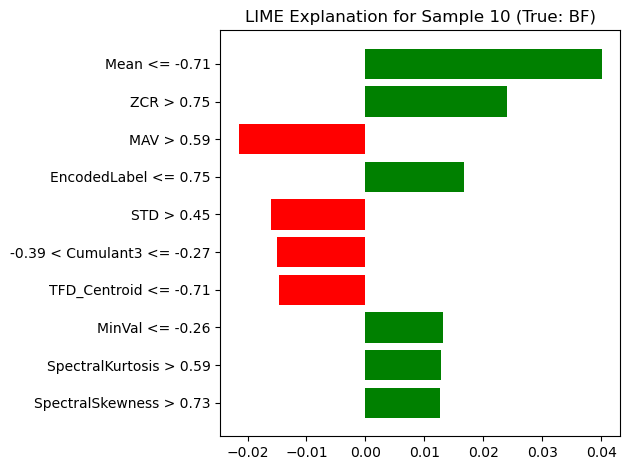

In [22]:
fig = exp.as_pyplot_figure()
plt.title(f"LIME Explanation for Sample {sample_idx} (True: {le.inverse_transform([y_test[sample_idx]])[0]})")
plt.tight_layout()
#plt.savefig("lime_explanation_sample.png", dpi=300, bbox_inches='tight')
plt.show()


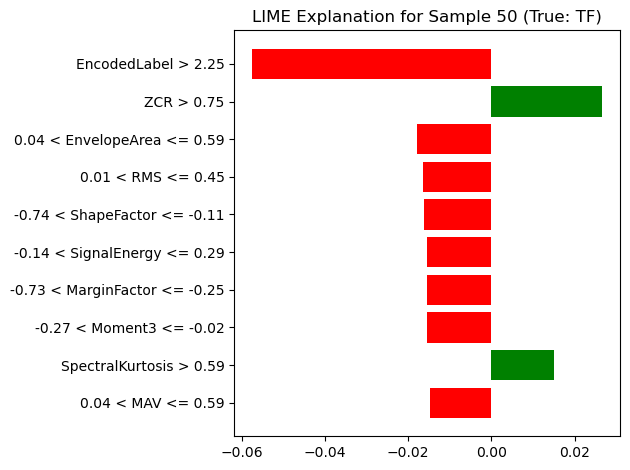

In [29]:
fig = exp.as_pyplot_figure()
plt.title(f"LIME Explanation for Sample {sample_idx} (True: {le.inverse_transform([y_test[sample_idx]])[0]})")
plt.tight_layout()
#plt.savefig("lime_explanation_sample.png", dpi=300, bbox_inches='tight')
plt.show()


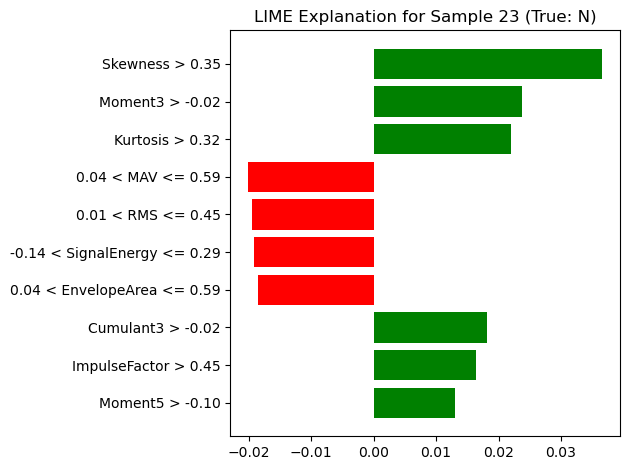

In [31]:
fig = exp.as_pyplot_figure()
plt.title(f"LIME Explanation for Sample {sample_idx} (True: {le.inverse_transform([y_test[sample_idx]])[0]})")
plt.tight_layout()
#plt.savefig("lime_explanation_sample.png", dpi=300, bbox_inches='tight')
plt.show()


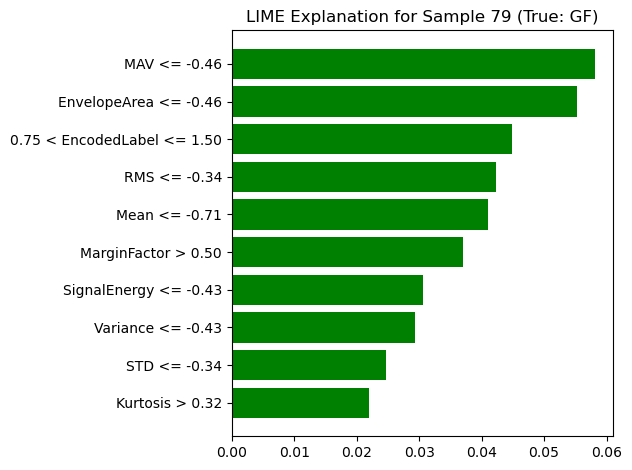

In [33]:
fig = exp.as_pyplot_figure()
plt.title(f"LIME Explanation for Sample {sample_idx} (True: {le.inverse_transform([y_test[sample_idx]])[0]})")
plt.tight_layout()
#plt.savefig("lime_explanation_sample.png", dpi=300, bbox_inches='tight')
plt.show()


c:\Users\Muhammad Umar\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


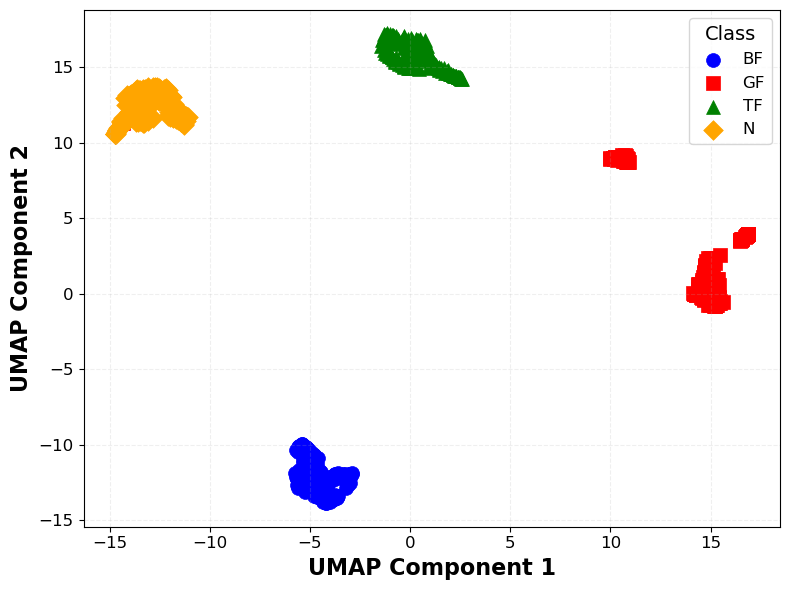

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import umap
from sklearn.preprocessing import LabelEncoder

# Define class names, markers, and colors (update as per your actual classes)
class_names = ['BF', 'GF', 'TF', 'N']
markers = ['o', 's', '^', 'D']  # Circle, square, triangle, diamond
colors = ['blue', 'red', 'green', 'orange']  # Unique colors per class

# Encode class labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)  # y must be your original class labels

# Supervised UMAP
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='euclidean',
                    random_state=42, target_metric='categorical')
X_umap_supervised = reducer.fit_transform(X_scaled, y=y_encoded)

# Plot with styled formatting
plt.figure(figsize=(8, 6))
for class_idx, (class_name, marker, color) in enumerate(zip(class_names, markers, colors)):
    class_mask = (y_encoded == class_idx)
    plt.scatter(X_umap_supervised[class_mask, 0], X_umap_supervised[class_mask, 1],
                marker=marker, color=color, label=class_name, s=100, linewidths=0.5)

plt.xlabel("UMAP Component 1", fontsize=16, fontweight='bold')
plt.ylabel("UMAP Component 2", fontsize=16, fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title="Class", title_fontsize=14, fontsize=12)
plt.grid(True, linestyle='--', alpha=0.2)
plt.tight_layout()
plt.show()


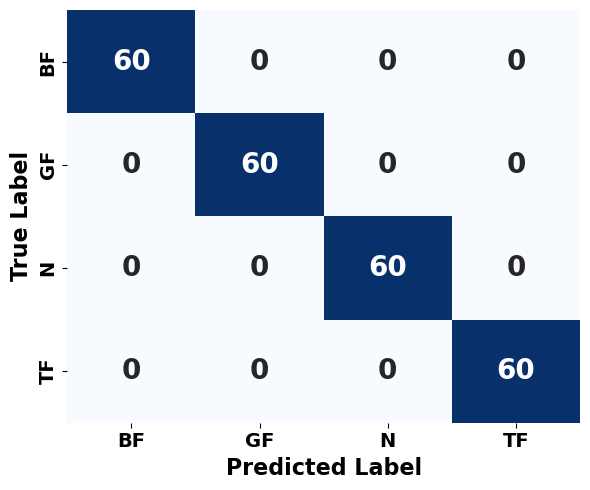

In [44]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion matrix and classification report
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)

# Define class labels (decoded)
class_labels = label_encoder.classes_

# Plot styled confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels,
            cbar=False, annot_kws={"size": 20, "fontweight": "bold"})

# Axis labels and styling
plt.xlabel('Predicted Label', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=16, fontweight='bold')
plt.xticks(fontsize=14, fontweight='bold')
plt.yticks(fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Muhammad Umar\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [00:41:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


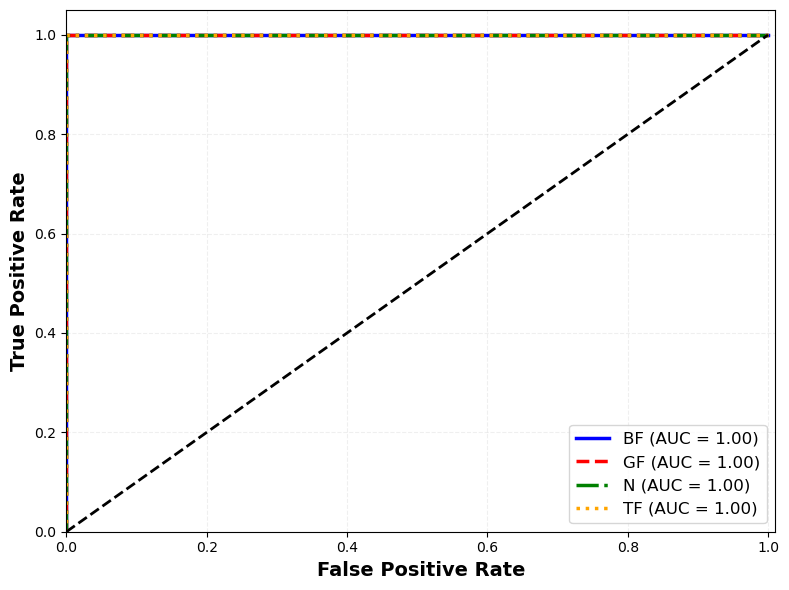


Classification Report:

              precision    recall  f1-score   support

          BF       1.00      1.00      1.00        60
          GF       1.00      1.00      1.00        60
           N       1.00      1.00      1.00        60
          TF       1.00      1.00      1.00        60

    accuracy                           1.00       240
   macro avg       1.00      1.00      1.00       240
weighted avg       1.00      1.00      1.00       240



In [60]:
# --------------------------------------------------
# 📦 Import Libraries
# --------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import roc_curve, auc, classification_report
from xgboost import XGBClassifier
from numpy import interp
from itertools import cycle

# --------------------------------------------------
# 📊 Prepare Data
# --------------------------------------------------
# Encode and scale
le = LabelEncoder()
y_encoded = le.fit_transform(y)
class_names = le.classes_
n_classes = len(class_names)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Binarize for ROC
y_binarized = label_binarize(y_encoded, classes=range(n_classes))

# --------------------------------------------------
# 🔀 Train/Test Split
# --------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.3, stratify=y_encoded, random_state=42
)
y_test_bin = label_binarize(y_test, classes=range(n_classes))

# --------------------------------------------------
# 🔍 Hyperparameter Tuning
# --------------------------------------------------
params = {
    'n_estimators': [200, 300, 400],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1, 0.2]
}

clf = XGBClassifier(
    objective='multi:softprob',
    num_class=n_classes,
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42
)

search = RandomizedSearchCV(
    estimator=clf,
    param_distributions=params,
    scoring='accuracy',
    n_iter=10,
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

search.fit(X_train, y_train)
best_clf = search.best_estimator_
y_score = best_clf.predict_proba(X_test)

# --------------------------------------------------
# 📈 Plot ROC
# --------------------------------------------------
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot
plt.figure(figsize=(8, 6))
colors = ['blue', 'red', 'green', 'orange']
styles = ['-', '--', '-.', ':']

for i in range(n_classes):
    plt.plot(
        fpr[i], tpr[i],
        color=colors[i], linestyle=styles[i], linewidth=2.5,
        label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})'
    )

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.01])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.2)
plt.tight_layout()
plt.show()

# --------------------------------------------------
# 📃 Optional: Classification Report
# --------------------------------------------------
y_pred = best_clf.predict(X_test)
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=class_names))


In [61]:
from sklearn.metrics import roc_auc_score

# Compute macro and micro AUC
macro_auc = roc_auc_score(y_test_bin, y_score, average='macro')
micro_auc = roc_auc_score(y_test_bin, y_score, average='micro')
print(f"Macro AUC: {macro_auc:.2f}")
print(f"Micro AUC: {micro_auc:.2f}")


Macro AUC: 1.00
Micro AUC: 1.00


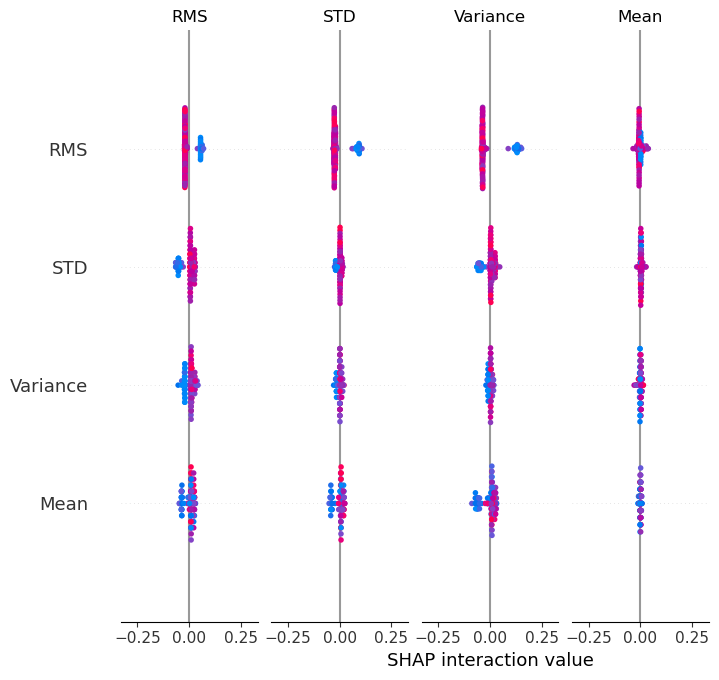

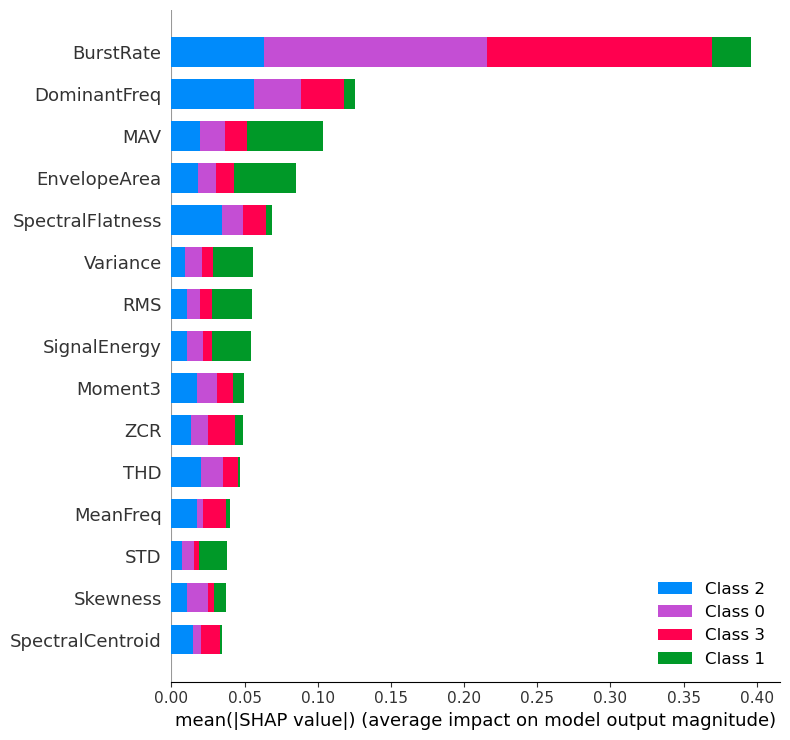

In [38]:
import shap
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import pandas as pd

# 1. Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# 2. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# 3. Train the classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# 4. SHAP TreeExplainer
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_test)

# 5. Provide feature names manually (MUST match X_test shape)
# Replace this with your actual list of 62 features used in X
feature_names = [
    "Mean", "RMS", "STD", "Variance", "Skewness", "Kurtosis",
    "Peak", "PeakToPeak", "CrestFactor", "ImpulseFactor", "ShapeFactor", "MarginFactor",
    "SignalEnergy", "MaxVal", "MinVal", "Range", "ZCR", "Duration", "MAV", "EnvelopeArea",
    "MeanFreq", "MedianFreq", "DominantFreq", "SpectralCentroid", "SpectralEntropy",
    "SpectralKurtosis", "SpectralSkewness", "SpectralFlatness", "SpectralEnergy",
    "FreqVariance", "FreqRMS", "FreqSpread", "THD",
    "TFD_Energy", "TFD_Entropy", "TFD_Mean", "TFD_STD", "TFD_Max",
    "TFD_Kurtosis", "TFD_Skewness", "TFD_Centroid", "TFD_RidgeEnergyRatio",
    "Moment3", "Moment4", "Moment5", "Cumulant3", "Cumulant4",
    "GaussianityIndex", "BispectrumMean", "BicoherenceMean", "NonlinearityIndex",
    "NumBursts", "AvgBurstDuration", "AvgInterBurstInterval",
    "AvgBurstEnergy", "AvgBurstPeak", "AvgBurstRMS",
    "CumulativeCounts", "TotalEventDuration",
    "MaxBurstPeak", "MinBurstPeak", "BurstRate"  # <-- Add this missing 62nd feature name
]


# Optional: if X_test is NumPy array, convert it to DataFrame with feature names
if isinstance(X_test, np.ndarray):
    X_test = pd.DataFrame(X_test, columns=feature_names)

# 6. SHAP Summary Plot - beeswarm (detailed)
shap.summary_plot(shap_values, X_test, feature_names=feature_names)

# 7. SHAP Summary Plot - bar chart (top features)
shap.summary_plot(shap_values, X_test, feature_names=feature_names, plot_type="bar", max_display=15)


In [65]:
import pandas as pd

# Load your Excel file
file_path = r"E:\2 Paper MCT\Multi-Domain Paper\full_ae_features.xlsx"
df = pd.read_excel(file_path)

# Show the first few rows
print(df.head())


       Mean       RMS       STD  Variance  Skewness  Kurtosis      Peak  \
0  0.145315  0.289073  0.289135  0.129524  0.021591 -0.856775 -0.399286   
1  0.215845 -0.092377 -0.092370 -0.226827 -0.620527 -0.626088 -0.505595   
2 -0.339205  0.316822  0.317000  0.157199  0.009176 -0.553562  0.076710   
3  0.129803 -0.081689 -0.081654 -0.217392  0.160027 -0.331105 -0.064855   
4 -0.136830  0.067469  0.067588 -0.082533  0.199573 -0.144834  0.379170   

   PeakToPeak  CrestFactor  ImpulseFactor  ...  AvgInterBurstInterval  \
0   -0.337318    -0.943950      -0.967978  ...              -0.745951   
1   -0.316129    -0.651600      -0.596835  ...              -0.215762   
2    0.389982    -0.477655      -0.480772  ...              -0.443069   
3   -0.084086    -0.148175      -0.287690  ...              -0.568438   
4    0.214197     0.155486       0.205955  ...               0.075776   

   AvgBurstEnergy  AvgBurstPeak  AvgBurstRMS  CumulativeCounts  \
0       -0.426716     -0.485721    -0.479723

In [66]:
# Separate features and labels
X = df.drop(columns=['Label'])  # replace 'Label' with actual column name if different
y = df['Label']


In [82]:
import shap
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Select the same 4 features for training and testing
selected_features = ["NumBursts", "DominantFreq", "MAV", "EnvelopeArea"]
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Fit the model on selected features
model = RandomForestClassifier(random_state=42)
model.fit(X_train_selected, y_train)

# SHAP Explainer and values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_selected)  # list with one array per class

# Check shape
print("shap_values[0] shape:", shap_values[0].shape)  # should be (n_samples, 4)
print("X_test_selected shape:", X_test_selected.shape)

# Initialize JS for visualization
shap.initjs()

# Dependence plots for each selected feature
for feature in selected_features:
    shap.dependence_plot(
        feature,
        shap_values[0],               # Use class 0 SHAP values or change to 1, 2... depending on class
        X_test_selected,              # Must match SHAP shape
        feature_names=selected_features
    )


shap_values[0] shape: (4, 4)
X_test_selected shape: (160, 4)


IndexError: index 4 is out of bounds for axis 0 with size 4

Available LIME explanation labels: [1]


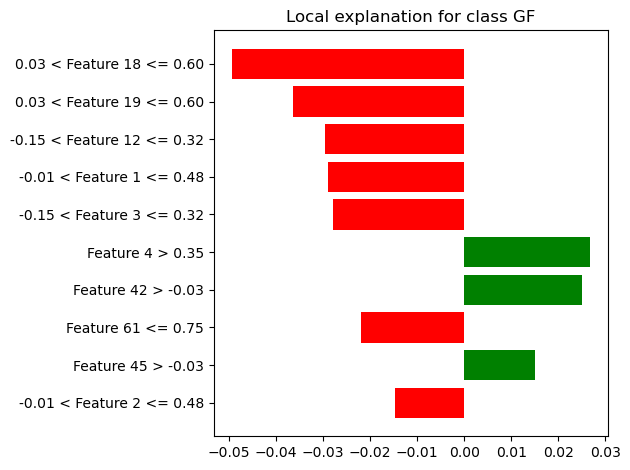

In [95]:
# Step 1: Check available keys
available_labels = list(exp.local_exp.keys())
print("Available LIME explanation labels:", available_labels)

# Step 2: Use the first available label (or pick as needed)
lime_label = available_labels[0]  # you can adjust this if needed

# Step 3: Replace feature names
exp_list_named = replace_feature_names(exp.as_list(label=lime_label), feature_names)

# Step 4: Plot manually
fig, ax = plt.subplots()
vals = [x[1] for x in exp_list_named]
names = [x[0] for x in exp_list_named]
colors = ['green' if v > 0 else 'red' for v in vals]

ax.barh(range(len(vals)), vals, color=colors, align='center')
ax.set_yticks(range(len(vals)))
ax.set_yticklabels(names)
ax.invert_yaxis()
ax.set_title(f"Local explanation for class {class_names[lime_label]}")
plt.tight_layout()
plt.show()


In [105]:
import umap
from sklearn.metrics import silhouette_score

# Reduce to 2D using UMAP
umap_model = umap.UMAP(n_components=2, random_state=42)
X_embedded = umap_model.fit_transform(X)

# Compute Silhouette Score
score = silhouette_score(X_embedded, y_encoded)
print("Silhouette Score (UMAP 2D):", round(score, 4))


c:\Users\Muhammad Umar\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Silhouette Score (UMAP 2D): 0.4177


In [106]:
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score

# t-SNE 2D
tsne = TSNE(n_components=2, random_state=42)
X_embedded = tsne.fit_transform(X)

# Silhouette
score = silhouette_score(X_embedded, y_encoded)
print("Silhouette Score (t-SNE):", round(score, 4))


Silhouette Score (t-SNE): 0.2877


In [107]:
# Total number of trainable parameters in TabNet
total_params = sum(p.numel() for p in tabnet.network.parameters() if p.requires_grad)
print(f"🔢 Total Trainable Parameters in TabNet: {total_params:,}")


🔢 Total Trainable Parameters in TabNet: 9,756


In [34]:
import pandas as pd

file_path = r"E:\2 Paper MCT\Multi-Domain Paper\full_ae_features.xlsx"
df = pd.read_excel(file_path)
df.head()


,Mean,RMS,STD,Variance,Skewness,Kurtosis,Peak,PeakToPeak,CrestFactor,ImpulseFactor,...,AvgInterBurstInterval,AvgBurstEnergy,AvgBurstPeak,AvgBurstRMS,CumulativeCounts,TotalEventDuration,MaxBurstPeak,MinBurstPeak,Label,EncodedLabel
0,0.145315,0.289073,0.289135,0.129524,0.021591,-0.856775,-0.399286,-0.337318,-0.943950,-0.967978,...,-0.745951,-0.426716,-0.485721,-0.479723,1.420232,1.420232,-0.399286,-0.430434,BF,0
1,0.215845,-0.092377,-0.092370,-0.226827,-0.620527,-0.626088,-0.505595,-0.316129,-0.651600,-0.596835,...,-0.215762,-0.256265,-0.321163,-0.365662,0.509820,0.509820,-0.505595,-0.506474,BF,0
2,-0.339205,0.316822,0.317000,0.157199,0.009176,-0.553562,0.076710,0.389982,-0.477655,-0.480772,...,-0.443069,-0.092744,-0.078467,-0.021805,0.574850,0.574850,0.076710,0.041933,BF,0
3,0.129803,-0.081689,-0.081654,-0.217392,0.160027,-0.331105,-0.064855,-0.084086,-0.148175,-0.287690,...,-0.568438,-0.425852,-0.304779,-0.250329,-0.194665,-0.194665,-0.064855,-0.084746,BF,0
4,-0.136830,0.067469,0.067588,-0.082533,0.199573,-0.144834,0.379170,0.214197,0.155486,0.205955,...,0.075776,0.022199,0.230161,0.265680,-0.362658,-0.362658,0.379170,0.367649,BF,0


In [35]:
from sklearn.preprocessing import StandardScaler

X = df.drop('Label', axis=1)  # Assuming 'Label' is the class
y = df['Label']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


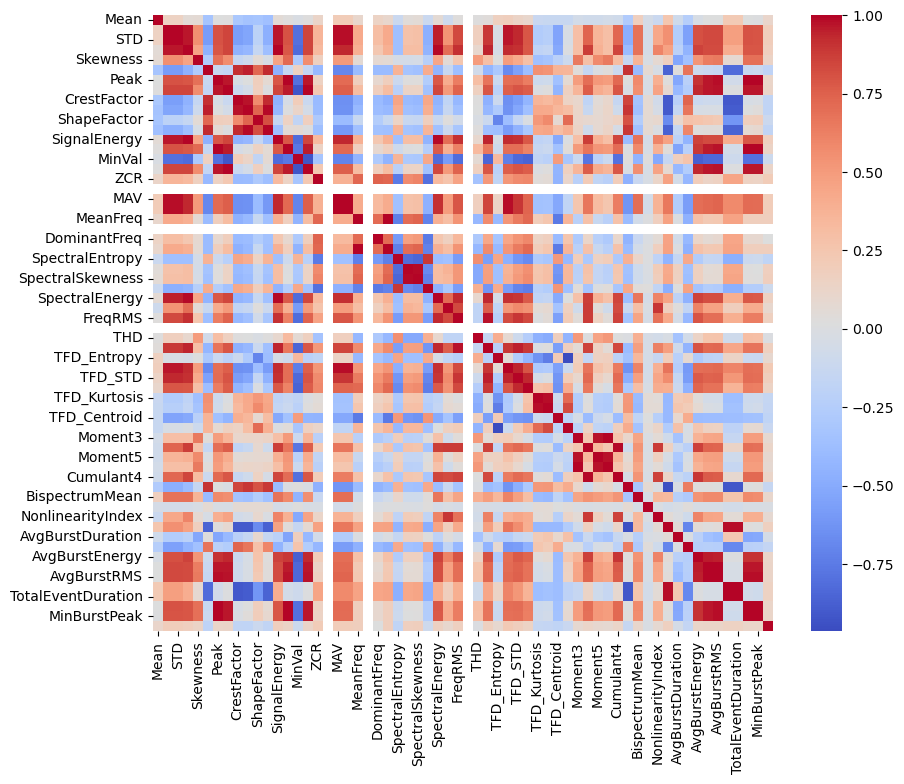

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(pd.DataFrame(X_scaled, columns=X.columns).corr(), cmap='coolwarm', annot=False)

plt.show()


Top 15 Important Features:
             Feature  Importance
61      EncodedLabel    0.225276
22      DominantFreq    0.071981
18               MAV    0.046820
19      EnvelopeArea    0.044231
27  SpectralFlatness    0.029232
1                RMS    0.029103
12      SignalEnergy    0.026713
3           Variance    0.025186
16               ZCR    0.024849
32               THD    0.022245
42           Moment3    0.021890
23  SpectralCentroid    0.020309
20          MeanFreq    0.019821
4           Skewness    0.019274
2                STD    0.019167


C:\Users\Muhammad Umar\AppData\Local\Temp\ipykernel_3036\3210358410.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance_df.head(15), x='Importance', y='Feature', palette='viridis')


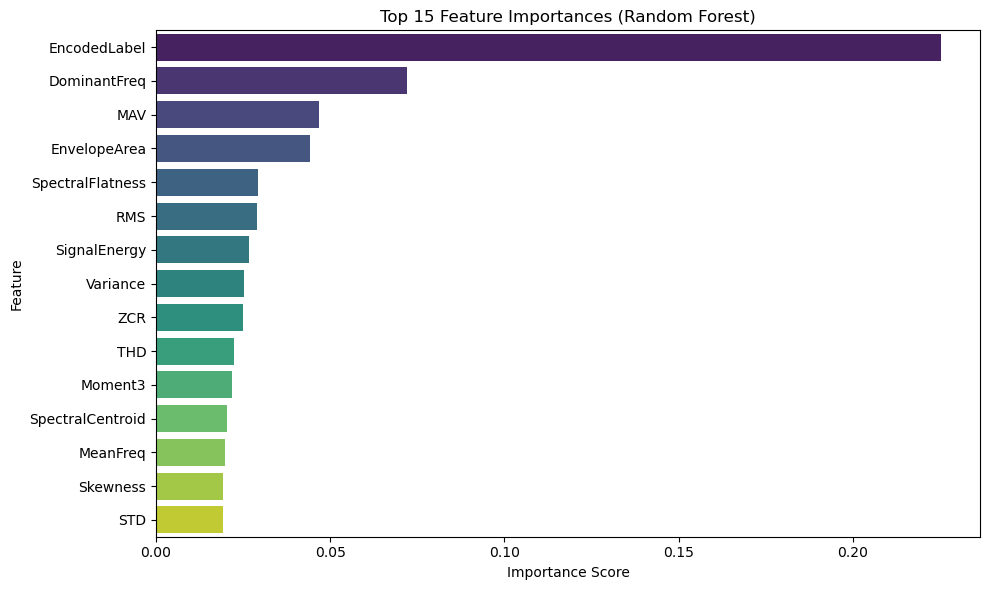

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# 1. Load your Excel file
file_path = "E:/2 Paper MCT/Multi-Domain Paper/full_ae_features.xlsx"  # update if needed
df = pd.read_excel(file_path)

# 2. Separate features and labels (Assuming 'Label' or similar column for classes)
X = df.drop(columns=['Label'])  # change 'Label' to your actual label column name
y = df['Label']

# 3. Encode labels if they are categorical
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# 4. Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# 5. Train a RandomForest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# 6. Get feature importances
importances = clf.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# 7. Display top 15 features
print("Top 15 Important Features:")
print(feature_importance_df.head(15))

# 8. Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance_df.head(15), x='Importance', y='Feature', palette='viridis')
plt.title('Top 15 Feature Importances (Random Forest)')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()
